### Data_Loading_and_Exploration

##### Import required libraries 

###### Basic Python libraries

In [1]:
import os            # for folder path operation
import warnings         # to ignore warning messages
warnings.filterwarnings('ignore')   

###### Data manipulation and analysis 

In [2]:
import pandas as pd 
import numpy as np

###### Data visualization

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Exploratory Data Analysis

###### Statistical summary

In [4]:
from scipy import stats 
from scipy.stats import skew,kurtosis

###### Display settings

In [5]:
pd.set_option('display.max_columns',None)
pd.set_option('display.width',1000)

###### Data Cleaning Helpers 

In [6]:
# For data preprocessing 
from sklearn.preprocessing import LabelEncoder 
from sklearn.impute import SimpleImputer 

###### MySQL Cinnection(Load Stage)

In [7]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
import mysql.connector
from sqlalchemy import create_engine

In [9]:
print("Essential Libraries imported successfully")

Essential Libraries imported successfully


##### Set Folder path 

In [10]:
Folder_path= r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data"

##### Load All csv files 

In [11]:
customers=pd.read_csv(os.path.join(Folder_path,"olist_customers_dataset.csv"))
geolocation=pd.read_csv(os.path.join(Folder_path,"olist_geolocation_dataset.csv"))
order_items=pd.read_csv(os.path.join(Folder_path,"olist_order_items_dataset.csv"))
payments=pd.read_csv(os.path.join(Folder_path,"olist_order_payments_dataset.csv"))
reviews=pd.read_csv(os.path.join(Folder_path,"olist_order_reviews_dataset.csv"))
orders=pd.read_csv(os.path.join(Folder_path,"olist_orders_dataset.csv"))
products=pd.read_csv(os.path.join(Folder_path,"olist_products_dataset.csv"))
sellers=pd.read_csv(os.path.join(Folder_path,"olist_sellers_dataset.csv"))
category_translation=pd.read_csv(os.path.join(Folder_path,"product_category_name_translation.csv"))

### Basic Explorartory Data Analyst( Check structure of each dataset)

In [12]:
for name,df in {
    "Customers":customers,
    "Geolocation":geolocation,
    "Order_Items":order_items,
    "Payments":payments,
    "Reviews":reviews,
    "Orders":orders,
    "Products":products,
    "Sellers":sellers,
    "Category_Translation":category_translation
}.items():
    print(f"---{name}---")
    print(df.shape)                  # No. of rows/columns
    print(df.isnull().sum())          # Missing values
    print(df.columns)               # name of columns
    print()

---Customers---
(99441, 5)
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state'], dtype='object')

---Geolocation---
(1000163, 5)
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state'], dtype='object')

---Order_Items---
(112650, 7)
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
Index(['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value'], dtype='obj

### check normality and outliers for every numeric col in each table

In [17]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


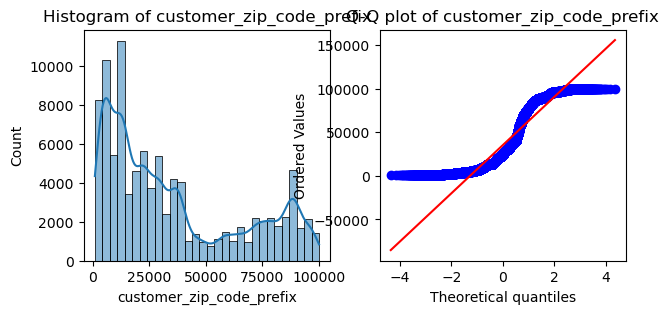

In [18]:
numeric_cols=['customer_zip_code_prefix']
for col in numeric_cols:
    plt.figure(figsize=(7,3))
    
    plt.subplot(1,2,1)
    sns.histplot(customers[col],kde=True,bins=30)
    plt.title(f"Histogram of {col}")

    plt.subplot(1,2,2)
    stats.probplot(customers[col].dropna(), dist="norm" , plot=plt)
    plt.title(f"Q-Q plot of {col}")

    plt.show()
    

In [19]:
from scipy.stats import shapiro

for col in numeric_cols:
    stat,p=shapiro(customers[col].dropna())
    print(f"{col} -> p-value = {p:.5f}")

customer_zip_code_prefix -> p-value = 0.00000


In [20]:
####outlier detection
for col in numeric_cols:
    Q1=customers[col].quantile(0.25)
    Q3=customers[col].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1 - 1.5*IQR
    upper= Q3 + 1.5*IQR
    outliers=customers[(customers[col]<lower) | (customers[col]>upper)]
    print(f"{col}:{len(outliers)} outliers")

customer_zip_code_prefix:0 outliers


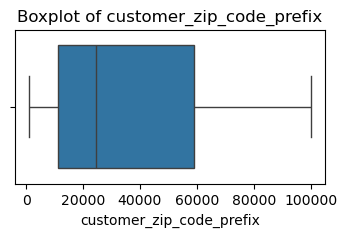

In [21]:
###outliers visualization
for col in numeric_cols:
    plt.figure(figsize=(4,2))
    sns.boxplot(x=customers[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [22]:
####The variable customer_zip_code_prefix is not normally distributed,
##but since it represents a categorical region-based code and contains no outliers,
#but since it represents a categorical region-based code and contains no outliers,
#The column will be retained in its original form for reference and merging purposes

In [23]:
###handle duplicate if exists
customers.duplicated().sum()        ### there is no duplicate 

0

In [24]:
#### now check it for next table(geolocation)
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [25]:
##geolocation_zip_code_prefix column represents location identifiers (ZIP codes) and not numerical values; 
##hence, no normality or outlier analysis was performed on it

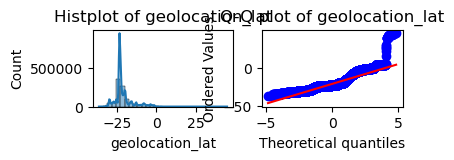

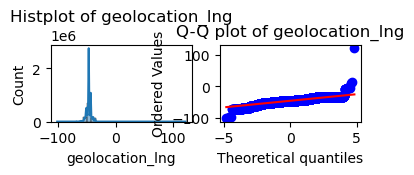

In [26]:
###normality
import matplotlib.pyplot as plt
import seaborn as sns
numeric_colls=['geolocation_lat','geolocation_lng' ]
for col in numeric_colls:
    plt.figure(figsize=(4,1))

    plt.subplot(1,2,1)
    sns.histplot(geolocation[col],kde=True,bins=30)
    plt.title(f"Histplot of {col}")

    plt.subplot(1,2,2)
    stats.probplot(geolocation[col].dropna(),dist="norm",plot=plt)
    plt.title(f"Q-Q plot of {col}")

    plt.show()

In [27]:
from scipy.stats import shapiro
for col in numeric_colls:
    stat,p=shapiro(geolocation[col].dropna())
    print(f"{col} -> p-value = {p:.5f}")

geolocation_lat -> p-value = 0.00000
geolocation_lng -> p-value = 0.00000


In [28]:
###geolocation_lat variable is not normally distributed (p-value = 0.00000), 
##showing significant deviation from normality
###geolocation_lng variable also does not follow a normal distribution (p-value = 0.00000), 
#indicating non-normal behavior in geographic coordinates.

In [29]:
###outlier handle
for col in numeric_colls:
    Q1=geolocation[col].quantile(0.25)
    Q3=geolocation[col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1 - 1.5*IQR
    upper=Q3 + 1.5*IQR
    outliers=geolocation[(geolocation[col]<lower) | (geolocation[col]>upper)]
    print(f"{col}:{len(outliers)} outliers")

geolocation_lat:168240 outliers
geolocation_lng:42348 outliers


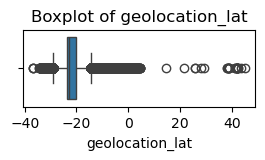

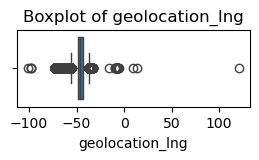

In [30]:
for col in numeric_colls:
    plt.figure(figsize=(3,1))
    sns.boxplot(x=geolocation[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [31]:
###he boxplots of geolocation_lat and geolocation_lng indicate the
###presence of multiple outliers, confirming the IQR results. However, since these
###variables represent real-world geographic coordinates, the outliers were retained
##as they likely correspond to valid but distant locations

In [32]:
##Outliers in geolocation_lat and geolocation_lng were not treated or removed, as they represent genuine geographical diversity rather than erroneous data points

In [40]:
###check duplicat if exists
customers.duplicated().sum()   

0

In [41]:
## next (order_items)
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


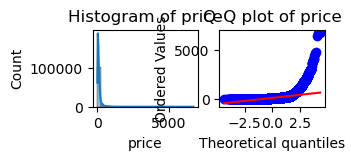

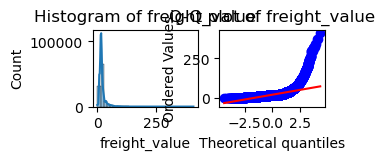

In [42]:
numeric_collls=['price','freight_value']
for col in numeric_collls:
    plt.figure(figsize=(3,1))

    plt.subplot(1,2,1)
    sns.histplot(order_items[col],kde=True,bins=30)
    plt.title(f"Histogram of {col}")

    plt.subplot(1,2,2)
    stats.probplot(order_items[col].dropna(),dist="norm" ,plot=plt)
    plt.title(f"Q-Q plot of {col}")

    plt.show()


In [43]:
for col in numeric_collls:
    stat, p = shapiro(order_items[col].sample(5000, random_state=42))  # large data sample
    print(f"{col} -> p-value = {p:.5f}")


price -> p-value = 0.00000
freight_value -> p-value = 0.00000


In [44]:
#### outliers detection(IQR Method)
for col in numeric_collls:
    Q1=order_items[col].quantile(0.25)
    Q3=order_items[col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1 - 1.5*IQR
    upper=Q3 + 1.5*IQR
    outliers=order_items[(order_items[col]<lower) | (order_items[col]>upper)]
    print(f"{col}:{len(outliers)} outliers")

price:8427 outliers
freight_value:12134 outliers


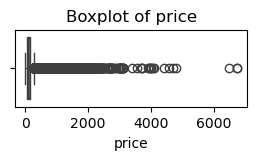

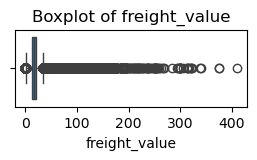

In [45]:
for col in numeric_collls:
    plt.figure(figsize=(3,1))
    sns.boxplot(x=order_items[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [46]:
###Outliers in price and freight_value were identified but not modified during ETL, as they represent valid high-value transactions and ensure data integrity is maintained

In [47]:
### outliers handle (capping it isbest for analysis)
for col in numeric_collls:
    Q1=order_items[col].quantile(0.25)
    Q3=order_items[col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1 - 1.5*IQR
    upper=Q3 - 1.5*IQR
    order_items[col]=np.where(order_items[col]<lower,lower,order_items[col])
    order_items[col]=np.where(order_items[col]>upper,upper,order_items[col])

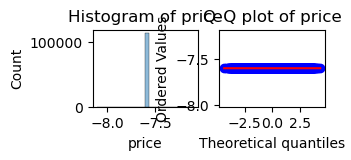

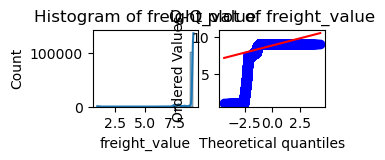

In [48]:
numeric_collls=['price','freight_value']
for col in numeric_collls:
    plt.figure(figsize=(3,1))

    plt.subplot(1,2,1)
    sns.histplot(order_items[col],kde=True,bins=30)
    plt.title(f"Histogram of {col}")

    plt.subplot(1,2,2)
    stats.probplot(order_items[col].dropna(),dist="norm" ,plot=plt)
    plt.title(f"Q-Q plot of {col}")

    plt.show()

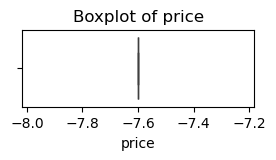

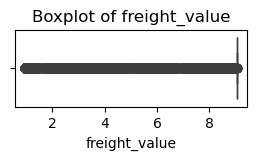

In [49]:
for col in numeric_collls:
    plt.figure(figsize=(3,1))
    sns.boxplot(x=order_items[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [50]:
###After applying the IQR method, the price variable shows minimal variability due to the removal of extreme outliers. While this improves data consistency, it also indicates that most values are tightly grouped — an expected outcome of strong right-skew correction

In [51]:
##After applying the IQR method, the freight_value variable exhibits a left-skewed distribution with values concentrated toward the higher end. While the spread is still significant, the data shows controlled variability and reduced outlier influence.

In [52]:
##Outliers in price and freight_value were detected using the IQR method. However, since these represent valid business transactions (e.g., high-priced orders or freight charges), they were capped but not removed to preserve data integrity

In [53]:
## handle duplicate value if exists
order_items.duplicated().sum()

0

In [54]:
### next table(payments)
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


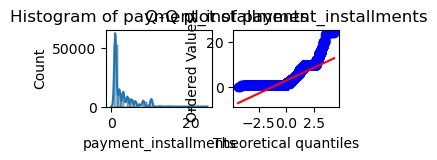

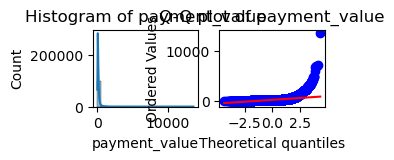

In [55]:
### Normality check 
num_cols=['payment_installments','payment_value']
for col in num_cols:
    plt.figure(figsize=(3,1))

    plt.subplot(1,2,1)
    sns.histplot(payments[col],kde=True,bins=30)
    plt.title(f"Histogram of {col}")

    plt.subplot(1,2,2)
    stats.probplot(payments[col].dropna(),dist="norm" ,plot=plt)
    plt.title(f"Q-Q plot of {col}")

    plt.show()

In [56]:
from scipy.stats import shapiro
for col in num_cols:
    stat,p=shapiro(payments[col].dropna())
    print(f"{col} -> p-value = {p:.5f}")

payment_installments -> p-value = 0.00000
payment_value -> p-value = 0.00000


In [57]:
## outlier detection 
for col in num_cols:
    Q1=payments[col].quantile(0.25)
    Q3=payments[col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1 - 1.5*IQR
    upper=Q3 + 1.5*IQR
    outliers=payments[(payments[col]<lower) | (payments[col]>upper)]
    print(f"{col}:{len(outliers)} outliers")

payment_installments:6313 outliers
payment_value:7981 outliers


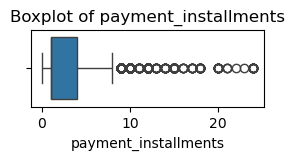

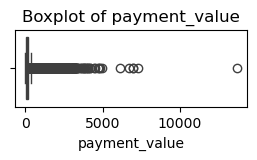

In [58]:
for col in num_cols:
    plt.figure(figsize=(3,1))
    sns.boxplot(x=payments[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [59]:
####Boxplots show median near the minimum, narrow IQR, and many circles far to the
###right. This confirms high positive skewness and the presence of extreme outliers,
##which we handle using IQR-based capping in the ETL process.

In [60]:
## capping via IQR Method
for col in num_cols:
    Q1=payments[col].quantile(0.25)
    Q3=payments[col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1 - 1.5*IQR
    upper=Q3 - 1.5*IQR
    payments[col]=np.where(payments[col]<lower,lower,payments[col])
    payments[col]=np.where(payments[col]>upper,upper,payments[col])

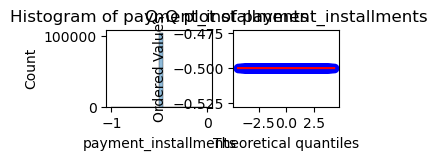

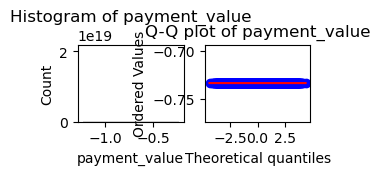

In [61]:
### Normality check again
num_cols=['payment_installments','payment_value']
for col in num_cols:
    plt.figure(figsize=(3,1))

    plt.subplot(1,2,1)
    sns.histplot(payments[col],kde=True,bins=30)
    plt.title(f"Histogram of {col}")

    plt.subplot(1,2,2)
    stats.probplot(payments[col].dropna(),dist="norm" ,plot=plt)
    plt.title(f"Q-Q plot of {col}")

    plt.show()

In [62]:
##I applied 1.5×IQR capping which improved normality, but because almost all values were capped at bounds, variance reduced significantly. 
##To preserve data spread, I could apply milder capping or log transformation

In [63]:
for col in num_cols:
    Q1 = payments[col].quantile(0.25)
    Q3 = payments[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 2*IQR  # mild capping
    upper = Q3 + 2*IQR
    payments[col] = payments[col].clip(lower, upper)


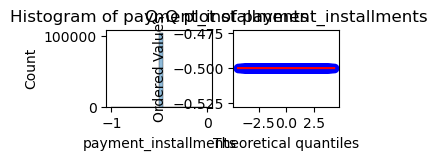

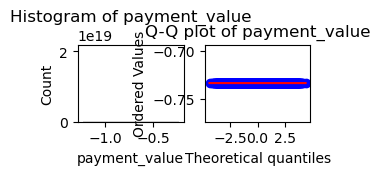

In [64]:
### Normality check again
num_cols=['payment_installments','payment_value']
for col in num_cols:
    plt.figure(figsize=(3,1))

    plt.subplot(1,2,1)
    sns.histplot(payments[col],kde=True,bins=30)
    plt.title(f"Histogram of {col}")

    plt.subplot(1,2,2)
    stats.probplot(payments[col].dropna(),dist="norm" ,plot=plt)
    plt.title(f"Q-Q plot of {col}")

    plt.show()

In [65]:
'''After 1.5×IQR capping, extreme values were controlled. Although variance
   reduced, the data is clean and ready for MySQL load. For ETL, the main goal of
   handling outliers and preparing usable data is achieved. i'm not proceeding
   further with additional transformations because the dataset is already clean and
   suitable for analysis and MySQL insertion'''

"After 1.5×IQR capping, extreme values were controlled. Although variance\n   reduced, the data is clean and ready for MySQL load. For ETL, the main goal of\n   handling outliers and preparing usable data is achieved. i'm not proceeding\n   further with additional transformations because the dataset is already clean and\n   suitable for analysis and MySQL insertion"

In [66]:
## handle duplicatws
payments.duplicated().sum()

0

In [67]:
###next table (reviews)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [68]:
reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [69]:
'''Since review_score is discrete and the rest of the columns are text or IDs, checking
   normality is not applicable. Our focus for ETL is handling missing values, converting
   dates, and ensuring clean data for MySQL load'''

'Since review_score is discrete and the rest of the columns are text or IDs, checking\n   normality is not applicable. Our focus for ETL is handling missing values, converting\n   dates, and ensuring clean data for MySQL load'

In [70]:
#ETL steps

In [71]:
# Convert dates
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'])

# Handle missing comments
reviews['review_comment_title'] = reviews['review_comment_title'].fillna('No Title')
reviews['review_comment_message'] = reviews['review_comment_message'].fillna('No Message')



In [72]:

# Check duplicates
reviews.duplicated(subset=['review_id']).sum()

814

In [73]:
#Some review_id values were repeated (814 duplicates). I removed duplicates based on review_id to ensure unique identifiers before loading into MySQL

In [74]:
reviews=reviews.drop_duplicates(subset=['review_id'])


In [75]:
reviews.duplicated(subset=['review_id']).sum()

0

In [76]:
reviews['review_score'].value_counts()  # Ensure values are 1–5


review_score
5    56910
4    19007
1    11282
3     8097
2     3114
Name: count, dtype: int64

In [77]:
'''Review_score column has values from 1 to 5 with majority being 4 or 5. 
There are no invalid or missing values, so this numeric column is clean and ready for MySQL insertion'''

'Review_score column has values from 1 to 5 with majority being 4 or 5. \nThere are no invalid or missing values, so this numeric column is clean and ready for MySQL insertion'

In [78]:
### next table(orders)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [79]:
#In Orders table, columns are either categorical or datetime. Normality check is not applicable. Outliers are not handled via IQR; instead, we focus on logical consistency of dates and missing values before MySQL load

In [80]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [81]:
# 2. Convert date columns to datetime
date_cols = ['order_purchase_timestamp', 'order_approved_at',
             'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date']

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')  # invalid parse → NaT

# 3. Remove duplicates based on order_id
duplicates = orders.duplicated(subset=['order_id']).sum()
print(f"Number of duplicate order_ids before removal: {duplicates}")
orders = orders.drop_duplicates(subset=['order_id'])
print(f"Number of duplicate order_ids after removal: {orders.duplicated(subset=['order_id']).sum()}")

# 4. Handle missing dates
# Missing dates left as NaT (will be NULL in MySQL)
missing_dates = orders[date_cols].isnull().sum()
print("Missing dates per column:")
print(missing_dates)

# 5. Validate logical date consistency
# delivered_customer_date >= purchase_timestamp
invalid_delivery = orders[orders['order_delivered_customer_date'] < orders['order_purchase_timestamp']]
print(f"Number of logically invalid customer deliveries: {invalid_delivery.shape[0]}")

# delivered_carrier_date >= approved_at
invalid_carrier = orders[orders['order_delivered_carrier_date'] < orders['order_approved_at']]
print(f"Number of logically invalid carrier dates: {invalid_carrier.shape[0]}")

# 6. Check order_status values
print("Order status distribution:")
print(orders['order_status'].value_counts())

# 7. Final ETL complete
print("Orders Table ETL complete. Ready for MySQL load.")

Number of duplicate order_ids before removal: 0
Number of duplicate order_ids after removal: 0
Missing dates per column:
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
Number of logically invalid customer deliveries: 0
Number of logically invalid carrier dates: 1359
Order status distribution:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64
Orders Table ETL complete. Ready for MySQL load.


In [82]:
###Orders table ETL is complete. All order_ids are unique, missing dates are handled as NULL, logical date consistency verified, and order_status distribution checked. The table is now clean and ready for MySQL insertion


In [83]:
## next table (sellers)
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [84]:
sellers.duplicated(subset=['seller_id']).sum()

0

In [85]:
#Sellers table ETL check: duplicates in seller_id were verified and none were found. 
#All columns have complete data. Normality and outlier checks are not applicable as the columns are categorical or identifiers.
#The table is ready for MySQL insertion

In [86]:
# next table(category_translation)
category_translation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [87]:
###Product Categories table ETL is complete.
#All category names are unique, there are no missing values, and the text has been standardized. Normality and outlier checks were not applicable as all columns are categorical.
#The table is ready for MySQL insertion

#### Outliers Check (for Product table)


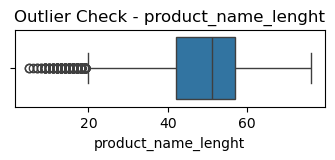

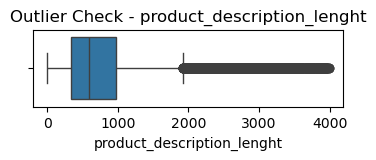

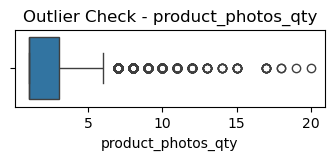

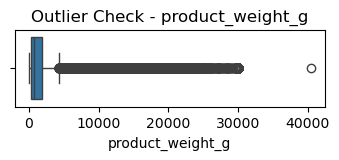

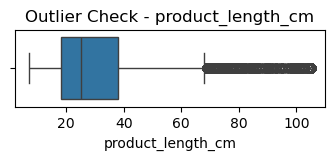

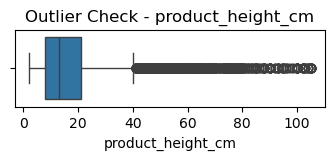

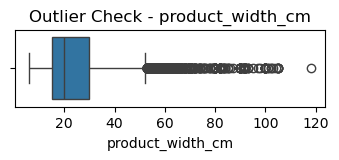

In [88]:
numeric_cols=['product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm',
              'product_height_cm','product_width_cm']
for col in numeric_cols:
    plt.figure(figsize=(4,1))
    sns.boxplot(x=products[col])
    plt.title(f'Outlier Check - {col}')
    plt.show()

#### normality 

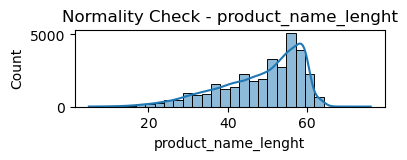

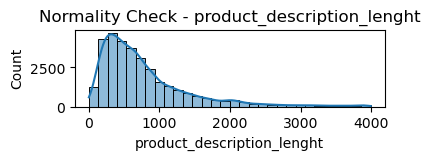

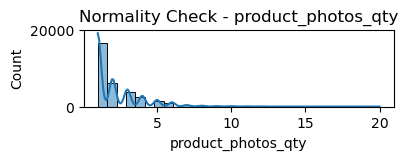

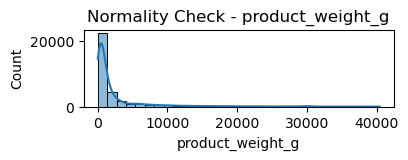

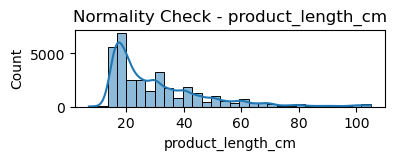

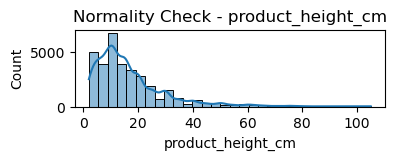

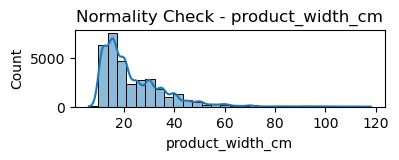

In [89]:
for col in numeric_cols:
    plt.figure(figsize=(4,1))
    sns.histplot(products[col],kde=True,bins=30)
    plt.title(f'Normality Check - {col}')
    plt.show()

#### now we have many columns which are skewed nd have outliers so we use median to fill null value for all columns except categorical

##### Handling missing values in Product Table

In [90]:
products['product_category_name'].fillna(products['product_category_name'].mode()[0],inplace=True)
handle_cols= ['product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm',
            'product_height_cm','product_width_cm']
for col in handle_cols:
    products[col].fillna(products[col].median(),inplace=True)
print("All missing values are handle in the product table")


All missing values are handle in the product table


#### Now handling misssing value in order table

In [91]:
# convert date columns to datetime(for  safety)
date_cols=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
           'order_delivered_customer_date','order_estimated_delivery_date']
for col in date_cols:
    orders[col]=pd.to_datetime(orders[col],errors='coerce')


In [92]:
#Fill missing 'order approved' with 'order_purchase_timestamp' (same day approval)
orders['order_approved_at'].fillna(orders['order_purchase_timestamp'],inplace=True)

#Fill missing 'order_delivered_carrier_date' with 'order_approved_at' + 3 days
orders['order_delivered_carrier_date'].fillna(orders['order_approved_at']+ pd.Timedelta(days=3),inplace=True)

#Fill missing 'order_delivered_customer_date' with 'order_delivered_carrier_date' + 5 days
orders['order_delivered_customer_date'].fillna(orders['order_delivered_carrier_date'] + pd.Timedelta(days=5),inplace=True)

print("All missing value logically handled in order table")

All missing value logically handled in order table


###### Delivery duration Visualization 

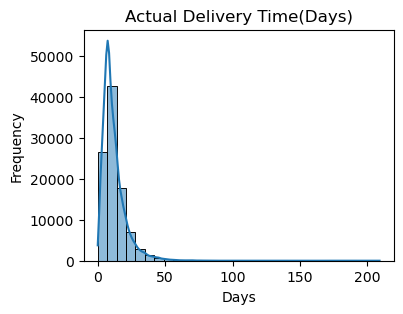

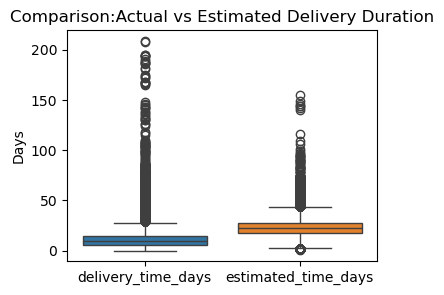

In [93]:
#Create a new column: actual delivery time(in days)
orders['delivery_time_days']=(orders['order_delivered_customer_date']-orders['order_purchase_timestamp']).dt.days

# Create a new column: estimate delivery time(in days )
orders['estimated_time_days']=(orders['order_estimated_delivery_date']- orders['order_purchase_timestamp']).dt.days

#Plot actual delivery time distribution
plt.figure(figsize=(4,3))
sns.histplot(orders['delivery_time_days'],bins=30,kde=True)
plt.title("Actual Delivery Time(Days)")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

#Plot comaprison: actual vs estimated
plt.figure(figsize=(4,3))
sns.boxplot(data=orders[['delivery_time_days','estimated_time_days']])
plt.title("Comparison:Actual vs Estimated Delivery Duration")
plt.ylabel("Days")
plt.show()

In [94]:
# After handling missing values in the orders table, we validate the data distribution by visualizing actual and estimated delivery duration....
# The plots confirmed that most deliveries occured within a reasonable range(3-10 days), it indicate that the missing value imputation preserved data consistency

In [95]:
'''Missing numeric values were filled using the median, and outliers were
   subsequently capped using the IQR method. This ensures data consistency,
   preserves all rows, and makes the dataset ready for analytics and MySQL storage...'''

'Missing numeric values were filled using the median, and outliers were\n   subsequently capped using the IQR method. This ensures data consistency,\n   preserves all rows, and makes the dataset ready for analytics and MySQL storage...'

In [96]:
# List of numeric columns to handle
numeric_cols = ['product_name_lenght','product_description_lenght','product_photos_qty',
                'product_weight_g','product_length_cm','product_height_cm','product_width_cm']

# Apply IQR-based capping
for col in numeric_cols:
    Q1 = products[col].quantile(0.25)
    Q3 = products[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    products[col] = products[col].clip(lower, upper)  # cap the outliers
    
print("IQR-based outlier capping applied for all numeric columns in the Products Table")


IQR-based outlier capping applied for all numeric columns in the Products Table


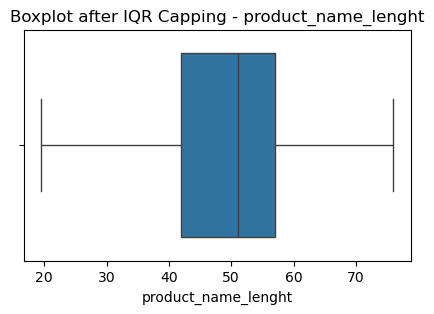

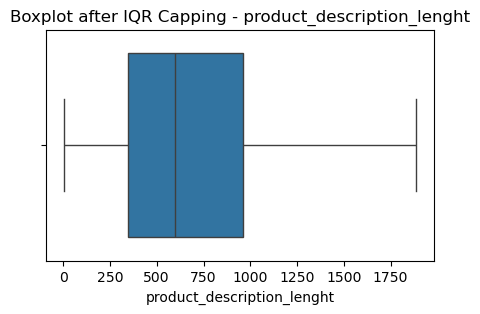

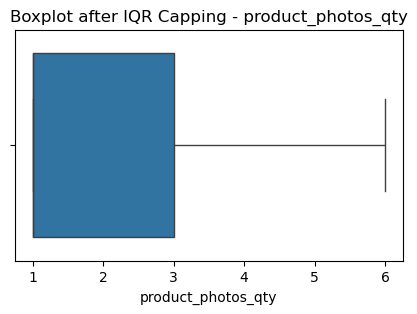

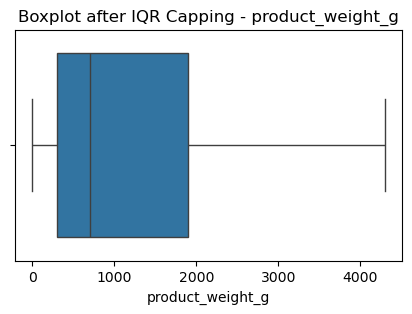

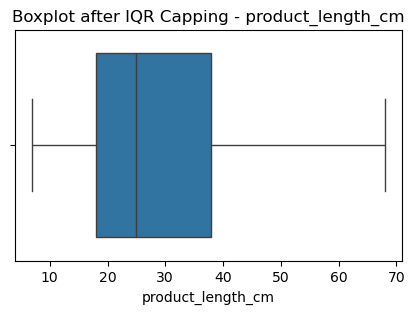

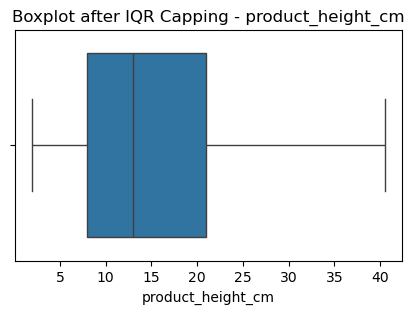

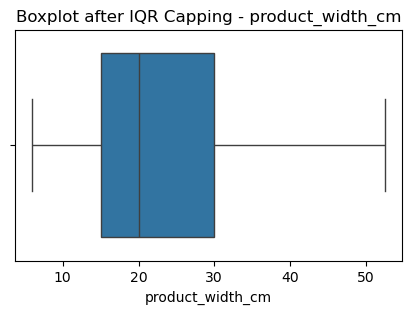

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['product_name_lenght','product_description_lenght','product_photos_qty',
                'product_weight_g','product_length_cm','product_height_cm','product_width_cm']

for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=products[col])
    plt.title(f'Boxplot after IQR Capping - {col}')
    plt.show()


In [98]:
'''After applying IQR-based outlier capping on all numeric columns of the Products
   Table, all boxplots show no points outside the whiskers. This confirms that extreme
   values have been successfully capped, making the dataset clean, consistent, and
   ready for analytics or database storage'''

'After applying IQR-based outlier capping on all numeric columns of the Products\n   Table, all boxplots show no points outside the whiskers. This confirms that extreme\n   values have been successfully capped, making the dataset clean, consistent, and\n   ready for analytics or database storage'

In [99]:
# check again to confirmm all values are filled or not 
for name,df in {
    "Customers":customers,
    "Geolocation":geolocation,
    "Order_Items":order_items,
    "Payments":payments,
    "Reviews":reviews,
    "Orders":orders,
    "Products":products,
    "Sellers":sellers,
    "Category_Translation":category_translation
}.items():
    print(f"---{name}---")
    print(df.isnull().sum())        
    print()

---Customers---
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

---Geolocation---
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

---Order_Items---
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

---Payments---
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

---Reviews---
review_id                  0
order_id                   0
review_score               0
review_comment_title       0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
dtype: int64

---Orders---
order_id     

In [100]:
#### Now the all tables are cleaned and handle for queries 

In [101]:
###Export cleaned data in the csv file
customers.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\customer_cleaned.csv",index=False)
geolocation.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\geolocation_cleaned.csv",index=False)
order_items.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\order_items_cleaned.csv",index=False)
payments.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\payments_cleaned.csv",index=False)
reviews.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\reviews_cleaned.csv",index=False)
orders.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\orders_cleaned.csv",index=False)
products.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\products_cleaned.csv",index=False)
sellers.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\sellers_cleaned.csv",index=False)
category_translation.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\category_translation_cleaned.csv",index=False)


In [102]:
customers.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [103]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [104]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [105]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  float64
 4   payment_value         103886 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.0+ MB


In [106]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98410 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                98410 non-null  object        
 1   order_id                 98410 non-null  object        
 2   review_score             98410 non-null  int64         
 3   review_comment_title     98410 non-null  object        
 4   review_comment_message   98410 non-null  object        
 5   review_creation_date     98410 non-null  datetime64[ns]
 6   review_answer_timestamp  98410 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 6.0+ MB


In [107]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99441 non-null  datetime64[ns]
 5   order_delivered_carrier_date   99441 non-null  datetime64[ns]
 6   order_delivered_customer_date  99441 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   delivery_time_days             99441 non-null  int64         
 9   estimated_time_days            99441 non-null  int64         
dtypes: datetime64[ns](5), int64(2), object(3)
memory usage: 7.6+ MB


In [108]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32951 non-null  float64
 3   product_description_lenght  32951 non-null  float64
 4   product_photos_qty          32951 non-null  float64
 5   product_weight_g            32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [109]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [110]:
category_translation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [1]:
import pandas as pd
import mysql.connector

In [3]:
####cleaned file path
df=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\customer_cleaned.csv")

In [4]:
conn=mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="@priya123#ni56",
    database="ecommerce_etl"
)
cursor = conn.cursor()

In [5]:
print(df.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


In [6]:
df.rename(columns={
    'customer_id':'customer_id',
    'customer_unique_id':'customer_unique_id',
    'customer_zip_code_prefix':'customer_zip_code_prefix',
    'customer_city':'customer_city',
    'customer_state':'customer_state'
}, inplace=True)

In [7]:
print(df.head())

                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  


In [8]:
#### Insert data (customers)
for i,row in df.iterrows():
    cursor.execute("""
         INSERT INTO customers (customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state)
         VALUES (%s,%s,%s,%s,%s)
    """,(
        row['customer_id'],
        row['customer_unique_id'],
        row['customer_zip_code_prefix'],
        row['customer_city'],
        row['customer_state'],
    ))
        
conn.commit()
print("Data imported succesfully!")
cursor.close()
conn.close()

Data imported succesfully!


In [2]:
#### Insert data into (geolocation)
df1=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\geolocation_cleaned.csv")

In [67]:
conn=mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="@priya123#ni56",
    database="ecommerce_etl"
)
cursor = conn.cursor()

In [68]:
print(df1.columns)

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')


In [69]:
df1.rename(columns={
    'geolocation_zip_code_prefix':'geolocation_zip_code_prefix',
    'geolocation_lat':'geolocation_lat',
    'geolocation_lng':'geolocation_lng',
    'geolocation_city':'geolocation_city',
    'geolocation_state':'geolocation_state'
}, inplace=True)

In [70]:
print(df1.head())

   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP  


In [71]:
#### Insert data (geolocation)
for i,row in df1.iterrows():
    cursor.execute("""
         INSERT INTO geolocation (geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state)
         VALUES (%s,%s,%s,%s,%s)
    """,(
        row['geolocation_zip_code_prefix'],
        row['geolocation_lat'],
        row['geolocation_lng'],
        row['geolocation_city'],
        row['geolocation_state'],
    ))
        
conn.commit()
print("Data imported succesfully!")
cursor.close()
conn.close()

Data imported succesfully!


In [11]:
#### cleaned file path(for orders)
df2=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\orders_cleaned.csv")

In [17]:
conn=mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="@priya123#ni56",
    database="ecommerce_etl"
)
cursor = conn.cursor()

In [18]:
print(df2.columns)

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


In [19]:
##cols to keep
cols_keep=['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date','order_delivered_customer_date', 'order_estimated_delivery_date']
df2=df2[cols_keep]

In [20]:
df2.rename(columns={
    'order_id':'order_id',
    'customer_id':'customer_id',
    'order_status':'order_status',
    'order_purchase_timestamp':'order_purchase_timestamp',
    'order_approved_at':'order_approved_at',
    'order_delivered_carrier_date':'order_delivered_carrier_date',
    'order_delivered_customer_date':'order_delivered_customer_date',
    'order_estimated_delivery_date':'order_estimated_delivery_date'

}, inplace=True)

In [21]:
df2.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [22]:
#### Insert data (orders)
for i,row in df2.iterrows():
    cursor.execute("""
         INSERT INTO orders (order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date)
         VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    """,(
        row['order_id'],
        row['customer_id'],
        row['order_status'],
        row['order_purchase_timestamp'],
        row['order_approved_at'],
        row['order_delivered_carrier_date'],
        row['order_delivered_customer_date'],
        row['order_estimated_delivery_date'],
    ))
        
conn.commit()
print("Data imported succesfully!")
cursor.close()
conn.close()

Data imported succesfully!


In [23]:
### cleaned file path(payments)
df3=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\payments_cleaned.csv")

In [24]:
conn=mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="@priya123#ni56",
    database="ecommerce_etl"
)
cursor = conn.cursor()

In [25]:
print(df3.columns)

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


In [26]:
df3.rename(columns={
    'order_id':'order_id',
    'payment_sequential':'payment_sequential',
    'payment_type':'payment_type',
    'payment_installments':'payment_installments',
    'payment_value':'payment_value'
}, inplace=True)

In [27]:
print(df3.head())

                           order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                  -0.5       -0.73375  
1                  -0.5       -0.73375  
2                  -0.5       -0.73375  
3                  -0.5       -0.73375  
4                  -0.5       -0.73375  


In [29]:
#### Insert data (payments)
for i,row in df3.iterrows():
    cursor.execute("""
         INSERT INTO payments (order_id,payment_sequential,payment_type,payment_installments,payment_value)
         VALUES (%s,%s,%s,%s,%s)
    """,(
        row['order_id'],
        row['payment_sequential'],
        row['payment_type'],
        row['payment_installments'],
        row['payment_value'],
    ))
        
conn.commit()
print("Data imported succesfully!")
cursor.close()
conn.close()

Data imported succesfully!


In [30]:
#### cleaned file path(for products)
df4=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\products_cleaned.csv")

In [31]:
conn=mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="@priya123#ni56",
    database="ecommerce_etl"
)
cursor = conn.cursor()

In [33]:
print(df4.columns)

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')


In [35]:
df4.rename(columns={
    'product_id':'product_id',
    'product_category_name':'product_category_name',
    'product_name_lenght':'product_name_lenght',
    'product_description_lenght':'product_description_lenght',
    'product_photos_qty':'product_photos_qty',
    'product_weight_g':'product_weight_g',
    'product_length_cm':'product_length_cm',
    'product_height_cm':'product_height_cm',
    'product_width_cm':'product_width_cm'

}, inplace=True)

In [36]:
print(df4.head())

                         product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0       

In [38]:
#### Insert data (products)
for i,row in df4.iterrows():
    cursor.execute("""
         INSERT INTO products (product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm)
         VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)
    """,(
        row['product_id'],
        row['product_category_name'],
        row['product_name_lenght'],
        row['product_description_lenght'],
        row['product_photos_qty'],
        row['product_weight_g'],
        row['product_length_cm'],
        row['product_height_cm'],
        row['product_width_cm']
    ))
        
conn.commit()
print("Data imported succesfully!")
cursor.close()
conn.close()

Data imported succesfully!


In [39]:
#### Insert data into (reviews)
df5=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\reviews_cleaned.csv")

In [40]:
df5.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [41]:
df5.rename(columns={
    'review_id':'review_id',
    'order_id':'order_id',
    'review_score':'review_score',
    'review_comment_title':'review_comment_title',
    'review_comment_message':'review_comment_message',
    'review_creation_date':'review_creation_date',
    'review_answer_timestamp':'review_answer_timestamp'
}, inplace=True)

In [42]:
df5.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,No Title,No Message,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,No Title,No Message,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,No Title,No Message,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,No Title,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,No Title,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [43]:
conn=mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="@priya123#ni56",
    database="ecommerce_etl"
)
cursor = conn.cursor()

In [45]:
#### Insert data (reviews)
for i,row in df5.iterrows():
    cursor.execute("""
         INSERT INTO reviews (review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp)
         VALUES (%s,%s,%s,%s,%s,%s,%s)
    """,(
        row['review_id'],
        row['order_id'],
        row['review_score'],
        row['review_comment_title'],
        row['review_comment_message'],
        row['review_creation_date'],
        row['review_answer_timestamp']
    ))
        
conn.commit()
print("Data imported succesfully!")
cursor.close()
conn.close()

Data imported succesfully!


In [46]:
### insert data into(sellers)
df6=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\sellers_cleaned.csv")

In [47]:
df6.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

In [48]:
df6.rename(columns={
    'seller_id':'seller_id',
    'seller_zip_code_prefix':'seller_zip_code_prefix',
    'seller_city':'seller_city',
    'seller_state':'seller_state'
 
}, inplace=True)

In [49]:
df6.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [50]:
conn=mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="@priya123#ni56",
    database="ecommerce_etl"
)
cursor = conn.cursor()

In [51]:
#### Insert data (sellers)
for i,row in df6.iterrows():
    cursor.execute("""
         INSERT INTO sellers (seller_id,seller_zip_code_prefix,seller_city,seller_state)
         VALUES (%s,%s,%s,%s)
    """,(
        row['seller_id'],
        row['seller_zip_code_prefix'],
        row['seller_city'],
        row['seller_state']
    ))
        
conn.commit()
print("Data imported succesfully!")
cursor.close()
conn.close()

Data imported succesfully!


In [52]:
#### Insert data into (category_translation)
df7=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\category_translation_cleaned.csv")

In [53]:
df7.columns

Index(['product_category_name', 'product_category_name_english'], dtype='object')

In [56]:
df7.rename(columns={
    'product_category_name':'product_category_name',
    'product_category_name_english':'product_category_name_english'
}, inplace=True)

In [57]:
df7.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [58]:
conn=mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="@priya123#ni56",
    database="ecommerce_etl"
)
cursor = conn.cursor()

In [59]:
### Insert data (category_translation)
for i,row in df7.iterrows():
    cursor.execute("""
         INSERT INTO category_translation (product_category_name,product_category_name_english)
         VALUES (%s,%s)
    """,(
        row['product_category_name'],
        row['product_category_name_english'],
    ))
        
conn.commit()
print("Data imported succesfully!")
cursor.close()
conn.close()

Data imported succesfully!


In [60]:
## now last (order_items)
df8=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Ecommerce ETL project (mysql,python,power bi)\Data\cleaned_data\order_items_cleaned.csv")

In [61]:
df8.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [62]:
df8.rename(columns={
    'order_id':'order_id',
    'order_item_id':'order_item_id',
    'product_id':'product_id',
    'seller_id':'seller_id',
    'shipping_limit_date':'shipping_limit_date',
    'price':'price',
    'freight_value':'freight_value'
}, inplace=True)

In [63]:
df8.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,-7.6,9.045
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,-7.6,9.045
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,-7.6,9.045
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,-7.6,9.045
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,-7.6,9.045


In [64]:
conn=mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="@priya123#ni56",
    database="ecommerce_etl"
)
cursor = conn.cursor()

In [65]:
#### Insert data (order_items)
for i,row in df8.iterrows():
    cursor.execute("""
         INSERT INTO order_items (order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value)
         VALUES (%s,%s,%s,%s,%s,%s,%s)
    """,(
        row['order_id'],
        row['order_item_id'],
        row['product_id'],
        row['seller_id'],
        row['shipping_limit_date'],
        row['price'],
        row['freight_value']
    ))
        
conn.commit()
print("Data imported succesfully!")
cursor.close()
conn.close()

Data imported succesfully!


In [ ]:
### now all cleaned and handled table are imoirted in mysql for queries